In [1]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import tensorflow as tf
from scipy import stats
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")

2022-11-24 18:38:19.946807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/pritish/anaconda3/envs/jami/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df= pd.read_pickle('final_labelled_data.pkl')
df.head()

,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,uid1_DT_M_ct,uid2_DT_M_ct,uid1_id_02_ct,uid2_id_02_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15,isFraud
0,68.5,4,3417,500,42,38,1,166,65,19.0,...,1,1,0,0,1,1,1,1,1,0
1,29.0,4,7922,303,42,2,1,173,65,NaN,...,6,6,1,1,4,4,1,1,0,0
2,59.0,4,9383,389,42,58,2,178,65,287.0,...,4,4,0,0,2,2,2,2,1,0
3,50.0,4,6991,466,42,14,2,282,65,NaN,...,6,6,2,2,114,114,115,115,0,0
4,50.0,1,9262,413,42,2,1,241,65,NaN,...,1,1,1,1,1,1,1,1,0,0


In [3]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [4]:
def tpr_fpr_threshold_auc(Y, proba):
    
    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    return (fpr, tpr, threshold, roc_auc)

In [5]:
def train_test_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''
    
    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [6]:
def best_threshold(threshold,tpr,fpr):
    
    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''
    
    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):
    
    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);

In [7]:
def draw_confusion_matrix(Y, predicted):
    
    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

In [8]:
def normalize(X_train, X_test):
    '''
        Utility Function to scale the values of the Train, CV and Test Datasets between 0 and 1.
    '''
    
    for f in X_train.columns:

        min_val = X_train[f].min()
        max_val = X_train[f].max()
        
        X_train[f] = (X_train[f]-min_val)/(max_val-min_val)
        X_test[f] = (X_test[f]-min_val)/(max_val-min_val)
        
    return (X_train, X_test)

In [9]:
print("columns with null values: ")
print(list(df.columns[df.isnull().any()]))
print('===========================================')

missing_values = missing_values_table(df)
missing_values[:].style.background_gradient(cmap='Reds')

columns with null values: 
['dist1', 'D6', 'D8', 'D9', 'D12', 'D13', 'D14', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V18', 'V20', 'V30', 'V36', 'V37', 'V40', 'V44', 'V47', 'V48', 'V52', 'V54', 'V59', 'V70', 'V76', 'V78', 'V80', 'V81', 'V82', 'V87', 'V91', 'V99', 'V127', 'V130', 'V131', 'V139', 'V147', 'V158', 'V165', 'V166', 'V169', 'V171', 'V173', 'V174', 'V175', 'V176', 'V180', 'V183', 'V185', 'V195', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210', 'V215', 'V216', 'V220', 'V221', 'V223', 'V230', 'V234', 'V235', 'V238', 'V240', 'V241', 'V250', 'V252', 'V257', 'V258', 'V260', 'V262', 'V263', 'V264', 'V265', 'V268', 'V271', 'V274', 'V277', 'V282', 'V283', 'V289', 'V291', 'V303', 'V307', 'V310', 'V312', 'V314', 'V315', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'TransactionAmt_card1_std', 'TransactionAmt_card1_addr1_std', 'TransactionAmt_card1_addr1_P_emaildomain_std', 'D9_card1_mean', 'D9_card1_std', 'D9_card1_addr1_mean', 'D9_card1_addr1_std', 

,Missing Values,% of Total Values
D13,528586,89.500000
D14,528351,89.500000
D12,525821,89.000000
id_04,524214,88.800000
id_03,524214,88.800000
D6,517351,87.600000
D8,515612,87.300000
D9,515612,87.300000
id_10,515612,87.300000
id_09,515612,87.300000


In [10]:
X = df.drop(['isFraud','uid1_P_emaildomain_ct', 'uid2_P_emaildomain_ct'], axis=1)
y = df['isFraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
del df
print('Train shape:',X_train.shape)
print('Test shape:',X_test.shape)

Train shape: (442903, 294)
Test shape: (147635, 294)


In [11]:
X_test.isnull().any().sum()

137

In [12]:
X_train1 = X_train.fillna(-999)
X_test1 = X_test.fillna(-999)
X_train1, X_test1 = normalize(X_train1, X_test1)


del X_train, X_test

In [17]:
train1 = X_train1
train1['isFraud'] = y_train

test1 = X_test1

del X_train1, X_test1, y_train

In [18]:
y_train = train1.pop('isFraud')


X_train1 = train1
X_test1 = test1 


del train1

In [19]:
print("*"*60)
print("\n Train Dataset Set1 Shape : {} \n".format(X_train1.shape))
print("\n Test Dataset Set1 Shape : {} \n".format(X_test1.shape))
print("*"*60)

************************************************************

 Train Dataset Set1 Shape : (442903, 294) 


 Test Dataset Set1 Shape : (147635, 294) 

************************************************************


In [20]:
weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [21]:
conda install -c conda-forge pytorch-tabnet

Solving environment: done

## Package Plan ##

  environment location: /home/pritish/anaconda3/envs/jami

  added / updated specs:
    - pytorch-tabnet


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2022.10.11~ --> conda-forge::ca-certificates-2022.9.24-ha878542_0 None
  certifi            pkgs/main/linux-64::certifi-2022.9.24~ --> conda-forge/noarch::certifi-2022.9.24-pyhd8ed1ab_0 None


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [22]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [23]:
#Defining the machine learning models
model1 = DecisionTreeClassifier(random_state=3, class_weight='balanced')
model2 = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
model3 = XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
model4 = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax'
                      )

Device used : cpu


In [24]:
conda install lightgbm

Solving environment: done

## Package Plan ##

  environment location: /home/pritish/anaconda3/envs/jami

  added / updated specs:
    - lightgbm


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2022.9.2~ --> pkgs/main::ca-certificates-2022.10.11-h06a4308_0 None

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2022.9.24~ --> pkgs/main/linux-64::certifi-2022.9.24-py39h06a4308_0 None


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [25]:
conda install catboost

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [26]:
from catboost import CatBoostClassifier
import lightgbm as lgb

model5 = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 3,n_jobs = -1)
model6 = CatBoostClassifier(scale_pos_weight = weight,random_state = 3,eval_metric = 'AUC')

In [27]:
model1.fit(X_train1, y_train)
model2.fit(X_train1, y_train)
model3.fit(X_train1, y_train)
model4.fit(
    X_train1.to_numpy(),y_train.to_numpy(),
    eval_set=[(X_train1.to_numpy(), y_train.to_numpy()), (X_test1.to_numpy(), y_test.to_numpy())],
    eval_name=['train', 'test'],
    eval_metric=['auc','balanced_accuracy'],
    max_epochs=100, patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

epoch 0  | loss: 0.54584 | train_auc: 0.83149 | train_balanced_accuracy: 0.7527  | test_auc: 0.83388 | test_balanced_accuracy: 0.75419 |  0:01:55s
epoch 1  | loss: 0.45573 | train_auc: 0.85252 | train_balanced_accuracy: 0.76377 | test_auc: 0.84646 | test_balanced_accuracy: 0.75751 |  0:03:53s
epoch 2  | loss: 0.41918 | train_auc: 0.89763 | train_balanced_accuracy: 0.81275 | test_auc: 0.88673 | test_balanced_accuracy: 0.80598 |  0:05:48s
epoch 3  | loss: 0.39364 | train_auc: 0.9097  | train_balanced_accuracy: 0.82699 | test_auc: 0.89571 | test_balanced_accuracy: 0.81537 |  0:07:47s
epoch 4  | loss: 0.37661 | train_auc: 0.9212  | train_balanced_accuracy: 0.84105 | test_auc: 0.90308 | test_balanced_accuracy: 0.82433 |  0:09:49s
epoch 5  | loss: 0.3646  | train_auc: 0.92445 | train_balanced_accuracy: 0.8439  | test_auc: 0.90607 | test_balanced_accuracy: 0.82727 |  0:11:44s
epoch 6  | loss: 0.35517 | train_auc: 0.93164 | train_balanced_accuracy: 0.85043 | test_auc: 0.90781 | test_balanced_a

In [28]:
model5.fit(X_train1, y_train)
model6.fit(X_train1, y_train)

Learning rate set to 0.138966
0:	total: 83.1ms	remaining: 1m 23s
1:	total: 113ms	remaining: 56.5s
2:	total: 143ms	remaining: 47.7s
3:	total: 170ms	remaining: 42.4s
4:	total: 197ms	remaining: 39.2s
5:	total: 230ms	remaining: 38.2s
6:	total: 257ms	remaining: 36.5s
7:	total: 288ms	remaining: 35.7s
8:	total: 313ms	remaining: 34.4s
9:	total: 340ms	remaining: 33.7s
10:	total: 367ms	remaining: 33s
11:	total: 396ms	remaining: 32.6s
12:	total: 425ms	remaining: 32.3s
13:	total: 453ms	remaining: 31.9s
14:	total: 481ms	remaining: 31.6s
15:	total: 506ms	remaining: 31.1s
16:	total: 534ms	remaining: 30.9s
17:	total: 562ms	remaining: 30.7s
18:	total: 591ms	remaining: 30.5s
19:	total: 619ms	remaining: 30.3s
20:	total: 646ms	remaining: 30.1s
21:	total: 678ms	remaining: 30.1s
22:	total: 709ms	remaining: 30.1s
23:	total: 736ms	remaining: 29.9s
24:	total: 766ms	remaining: 29.9s
25:	total: 793ms	remaining: 29.7s
26:	total: 822ms	remaining: 29.6s
27:	total: 848ms	remaining: 29.4s
28:	total: 876ms	remaining: 

245:	total: 7.19s	remaining: 22s
246:	total: 7.21s	remaining: 22s
247:	total: 7.24s	remaining: 22s
248:	total: 7.27s	remaining: 21.9s
249:	total: 7.3s	remaining: 21.9s
250:	total: 7.33s	remaining: 21.9s
251:	total: 7.35s	remaining: 21.8s
252:	total: 7.38s	remaining: 21.8s
253:	total: 7.4s	remaining: 21.7s
254:	total: 7.43s	remaining: 21.7s
255:	total: 7.46s	remaining: 21.7s
256:	total: 7.49s	remaining: 21.6s
257:	total: 7.52s	remaining: 21.6s
258:	total: 7.55s	remaining: 21.6s
259:	total: 7.58s	remaining: 21.6s
260:	total: 7.61s	remaining: 21.5s
261:	total: 7.64s	remaining: 21.5s
262:	total: 7.66s	remaining: 21.5s
263:	total: 7.69s	remaining: 21.4s
264:	total: 7.72s	remaining: 21.4s
265:	total: 7.75s	remaining: 21.4s
266:	total: 7.77s	remaining: 21.3s
267:	total: 7.82s	remaining: 21.3s
268:	total: 7.84s	remaining: 21.3s
269:	total: 7.87s	remaining: 21.3s
270:	total: 7.91s	remaining: 21.3s
271:	total: 7.94s	remaining: 21.2s
272:	total: 7.96s	remaining: 21.2s
273:	total: 7.99s	remaining:

484:	total: 14s	remaining: 14.9s
485:	total: 14.1s	remaining: 14.9s
486:	total: 14.1s	remaining: 14.9s
487:	total: 14.1s	remaining: 14.8s
488:	total: 14.2s	remaining: 14.8s
489:	total: 14.2s	remaining: 14.8s
490:	total: 14.2s	remaining: 14.7s
491:	total: 14.3s	remaining: 14.7s
492:	total: 14.3s	remaining: 14.7s
493:	total: 14.3s	remaining: 14.7s
494:	total: 14.3s	remaining: 14.6s
495:	total: 14.4s	remaining: 14.6s
496:	total: 14.4s	remaining: 14.6s
497:	total: 14.4s	remaining: 14.5s
498:	total: 14.5s	remaining: 14.5s
499:	total: 14.5s	remaining: 14.5s
500:	total: 14.5s	remaining: 14.4s
501:	total: 14.5s	remaining: 14.4s
502:	total: 14.6s	remaining: 14.4s
503:	total: 14.6s	remaining: 14.4s
504:	total: 14.6s	remaining: 14.3s
505:	total: 14.6s	remaining: 14.3s
506:	total: 14.7s	remaining: 14.3s
507:	total: 14.7s	remaining: 14.2s
508:	total: 14.7s	remaining: 14.2s
509:	total: 14.8s	remaining: 14.2s
510:	total: 14.8s	remaining: 14.2s
511:	total: 14.8s	remaining: 14.1s
512:	total: 14.9s	rema

722:	total: 20.9s	remaining: 8.01s
723:	total: 20.9s	remaining: 7.98s
724:	total: 21s	remaining: 7.96s
725:	total: 21s	remaining: 7.93s
726:	total: 21s	remaining: 7.9s
727:	total: 21.1s	remaining: 7.87s
728:	total: 21.1s	remaining: 7.84s
729:	total: 21.1s	remaining: 7.81s
730:	total: 21.2s	remaining: 7.78s
731:	total: 21.2s	remaining: 7.76s
732:	total: 21.2s	remaining: 7.73s
733:	total: 21.2s	remaining: 7.7s
734:	total: 21.3s	remaining: 7.67s
735:	total: 21.3s	remaining: 7.64s
736:	total: 21.3s	remaining: 7.61s
737:	total: 21.4s	remaining: 7.58s
738:	total: 21.4s	remaining: 7.55s
739:	total: 21.4s	remaining: 7.53s
740:	total: 21.4s	remaining: 7.5s
741:	total: 21.5s	remaining: 7.47s
742:	total: 21.5s	remaining: 7.44s
743:	total: 21.5s	remaining: 7.41s
744:	total: 21.6s	remaining: 7.38s
745:	total: 21.6s	remaining: 7.35s
746:	total: 21.6s	remaining: 7.32s
747:	total: 21.6s	remaining: 7.29s
748:	total: 21.7s	remaining: 7.26s
749:	total: 21.7s	remaining: 7.23s
750:	total: 21.7s	remaining: 

960:	total: 27.8s	remaining: 1.13s
961:	total: 27.8s	remaining: 1.1s
962:	total: 27.8s	remaining: 1.07s
963:	total: 27.9s	remaining: 1.04s
964:	total: 27.9s	remaining: 1.01s
965:	total: 27.9s	remaining: 983ms
966:	total: 27.9s	remaining: 954ms
967:	total: 28s	remaining: 925ms
968:	total: 28s	remaining: 896ms
969:	total: 28s	remaining: 867ms
970:	total: 28.1s	remaining: 838ms
971:	total: 28.1s	remaining: 809ms
972:	total: 28.1s	remaining: 780ms
973:	total: 28.1s	remaining: 751ms
974:	total: 28.2s	remaining: 722ms
975:	total: 28.2s	remaining: 693ms
976:	total: 28.2s	remaining: 664ms
977:	total: 28.3s	remaining: 636ms
978:	total: 28.3s	remaining: 607ms
979:	total: 28.3s	remaining: 578ms
980:	total: 28.3s	remaining: 549ms
981:	total: 28.4s	remaining: 520ms
982:	total: 28.4s	remaining: 491ms
983:	total: 28.4s	remaining: 462ms
984:	total: 28.5s	remaining: 433ms
985:	total: 28.5s	remaining: 405ms
986:	total: 28.5s	remaining: 376ms
987:	total: 28.6s	remaining: 347ms
988:	total: 28.6s	remaining

In [29]:
y_pred1 = model1.predict(X_test1)
y_pred2 = model2.predict(X_test1)
y_pred3 = model3.predict(X_test1)
y_pred4 = model4.predict(X_test1.to_numpy())

In [30]:
y_pred5 = model5.predict(X_test1)
y_pred6 = model6.predict(X_test1)

### DecisionTreeClassifier

In [31]:
model1_train_proba = model1.predict_proba(X_train1)[:,1]
model1_test_proba = model1.predict_proba(X_test1)[:,1]

In [32]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, model1_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, model1_test_proba)

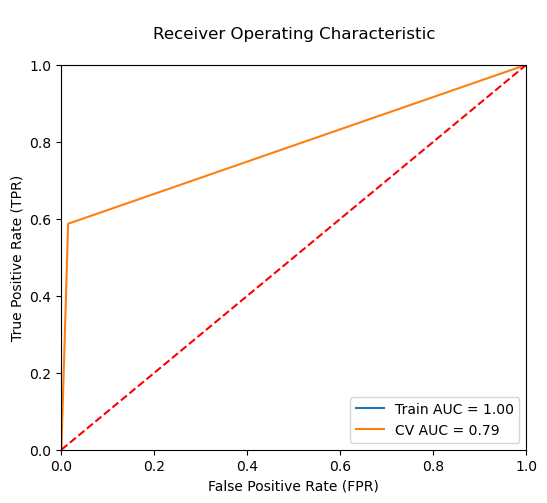

In [33]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

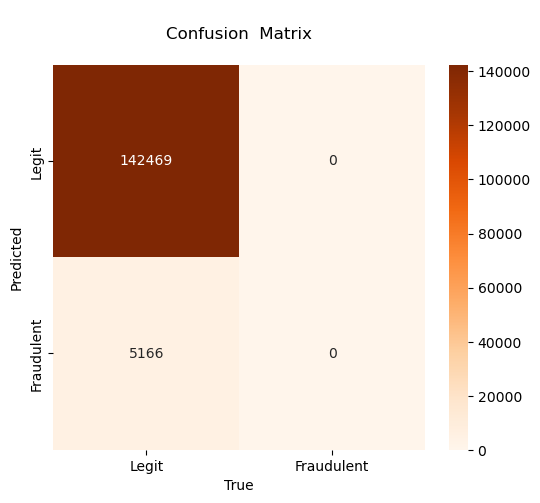

In [34]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, model1_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [35]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    142469
           1       0.60      0.59      0.59      5166

    accuracy                           0.97    147635
   macro avg       0.79      0.79      0.79    147635
weighted avg       0.97      0.97      0.97    147635



In [36]:
roc_auc_score(y_test, y_pred1)

0.7862205582758055

### RandomForestClassifier

In [37]:
model2_train_proba = model2.predict_proba(X_train1)[:,1]
model2_test_proba = model2.predict_proba(X_test1)[:,1]

In [38]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, model2_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, model2_test_proba)

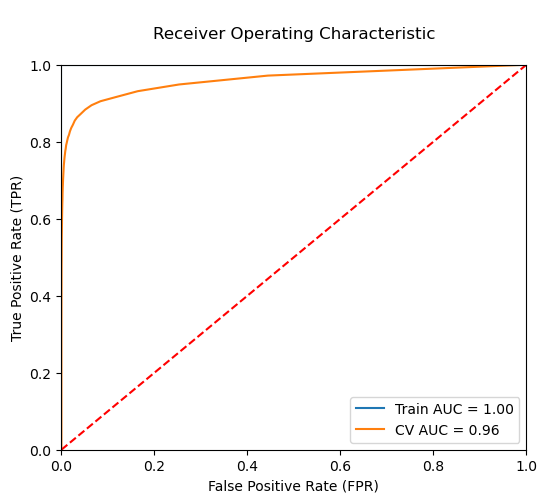

In [39]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

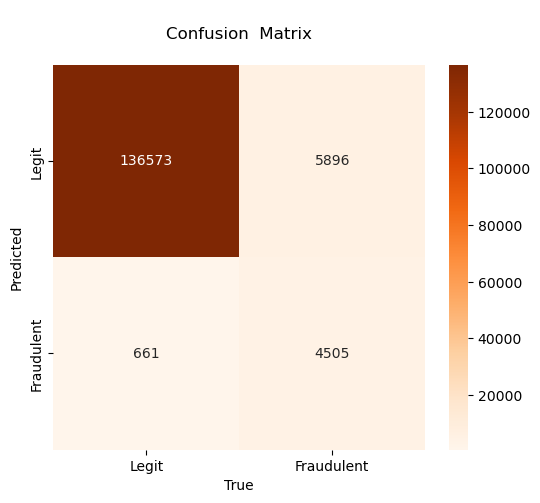

In [40]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, model2_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [41]:
print(classification_report(y_test,  y_pred2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142469
           1       0.96      0.56      0.70      5166

    accuracy                           0.98    147635
   macro avg       0.97      0.78      0.85    147635
weighted avg       0.98      0.98      0.98    147635



In [42]:
roc_auc_score(y_test, y_pred2)

0.7776610317169418

### XGBClassifier Classification

In [43]:
model3_train_proba = model3.predict_proba(X_train1)[:,1]
model3_test_proba = model3.predict_proba(X_test1)[:,1]

In [44]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, model3_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, model3_test_proba)

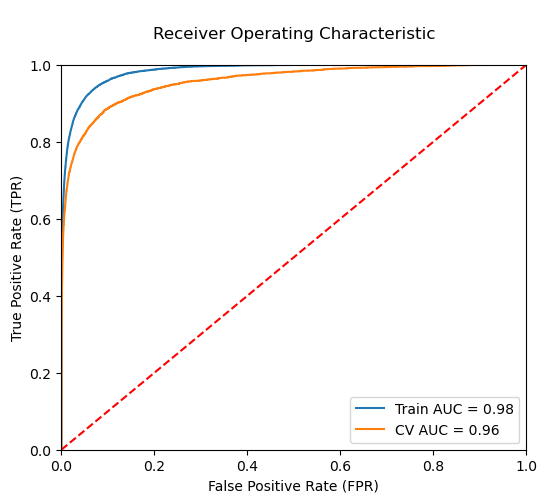

In [45]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

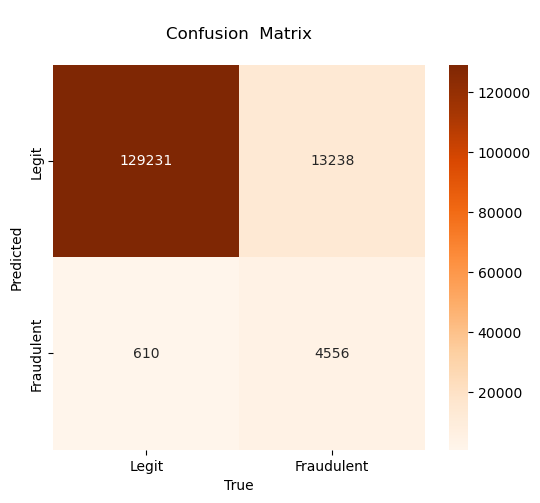

In [46]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, model3_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [47]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96    142469
           1       0.32      0.84      0.47      5166

    accuracy                           0.93    147635
   macro avg       0.66      0.89      0.72    147635
weighted avg       0.97      0.93      0.95    147635



In [48]:
roc_auc_score(y_test, y_pred3)

0.889741195799176

### TabNetClassifier

In [49]:
model4_train_proba = model4.predict_proba(X_train1.to_numpy())[:,1]
model4_test_proba = model4.predict_proba(X_test1.to_numpy())[:,1]

In [50]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, model4_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, model4_test_proba)

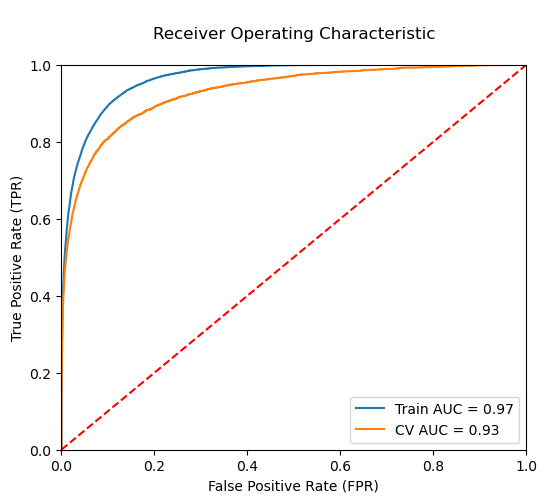

In [51]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

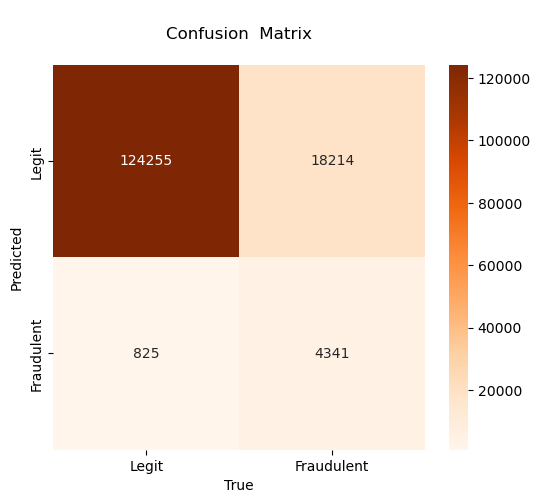

In [52]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, model4_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [53]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    142469
           1       0.17      0.86      0.28      5166

    accuracy                           0.85    147635
   macro avg       0.58      0.85      0.60    147635
weighted avg       0.97      0.85      0.89    147635



In [54]:
roc_auc_score(y_test, y_pred4)

0.8544776849757703

### LGBMClassifier Classification

In [56]:
model5_train_proba = model5.predict_proba(X_train1)[:,1]
model5_test_proba = model5.predict_proba(X_test1)[:,1]

In [57]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, model5_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, model5_test_proba)

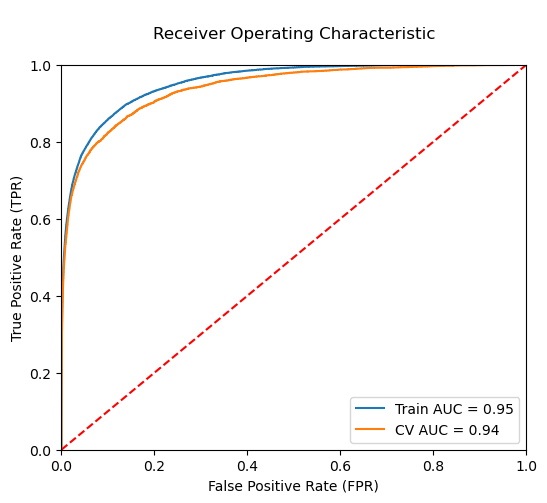

In [58]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

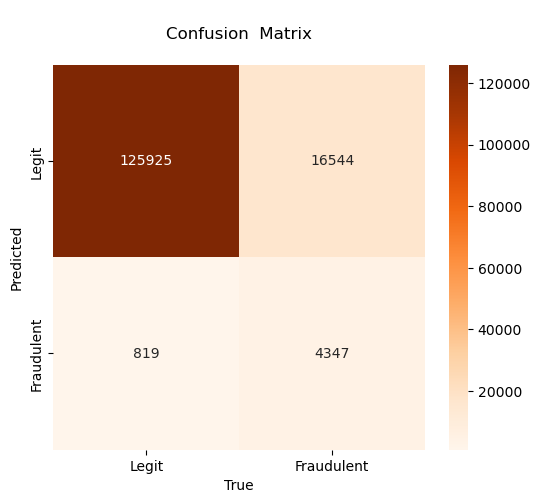

In [59]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, model5_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [61]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94    142469
           1       0.23      0.82      0.36      5166

    accuracy                           0.90    147635
   macro avg       0.61      0.86      0.65    147635
weighted avg       0.97      0.90      0.92    147635



In [62]:
roc_auc_score(y_test, y_pred5)

0.8614420305444147

### CatBoostClassifier

In [63]:
model6_train_proba = model6.predict_proba(X_train1)[:,1]
model6_test_proba = model6.predict_proba(X_test1)[:,1]

In [64]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, model6_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, model6_test_proba)

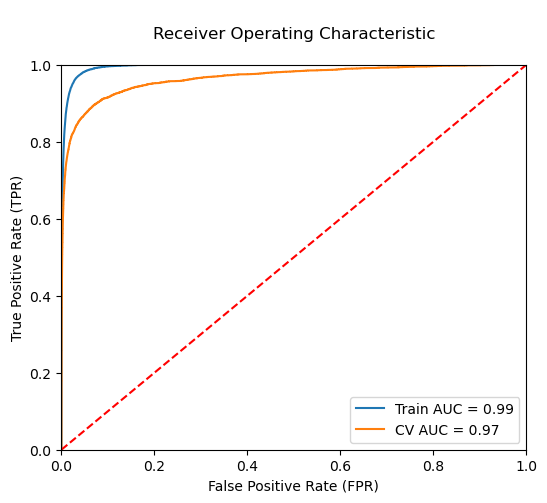

In [65]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

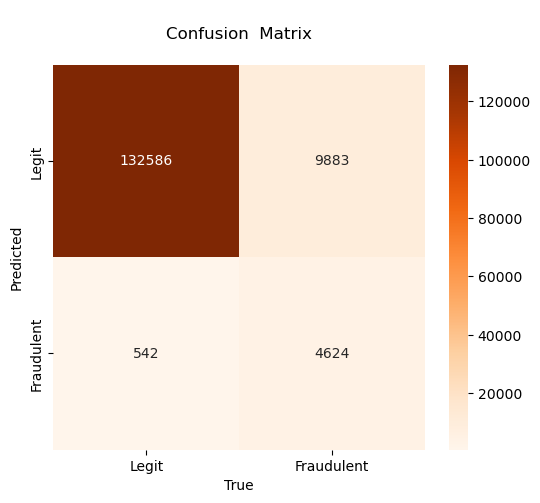

In [66]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, model6_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [68]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    142469
           1       0.43      0.86      0.57      5166

    accuracy                           0.95    147635
   macro avg       0.71      0.91      0.77    147635
weighted avg       0.97      0.95      0.96    147635



In [69]:
roc_auc_score(y_test, y_pred6)

0.9087648750054984

In [72]:
estimators = []

model11 = DecisionTreeClassifier(random_state=3, class_weight='balanced')
estimators.append(('dt1', model11))
model12 = DecisionTreeClassifier(random_state=3, class_weight='balanced')
estimators.append(('dt2', model12))
model13 = DecisionTreeClassifier(random_state=3, class_weight='balanced')
estimators.append(('dt3', model13))
model14 = DecisionTreeClassifier(random_state=3, class_weight='balanced')
estimators.append(('dt4', model14))
model15 = DecisionTreeClassifier(random_state=3, class_weight='balanced')
estimators.append(('dt5', model15))

model21 = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
estimators.append(('rf1', model21))
model22 = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
estimators.append(('rf2', model22))
model23 = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
estimators.append(('rf3', model23))
model24 = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
estimators.append(('rf4', model24))
model25 = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
estimators.append(('rf5', model25))


model31 = XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
estimators.append(('xgb1', model31))
model32 = XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
estimators.append(('xgb2', model32))
model33 = XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
estimators.append(('xgb3', model33))
model34 = XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
estimators.append(('xgb4', model34))
model35 = XGBClassifier(scale_pos_weight = weight, objective='binary:logistic', eval_metric = 'auc', 
                         random_state = 3, tree_method = 'hist')
estimators.append(('xgb5', model35))


model51 = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 3,n_jobs = -1)
estimators.append(('lgb1', model51))
model52 = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 3,n_jobs = -1)
estimators.append(('lgb2', model52))
model53 = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 3,n_jobs = -1)
estimators.append(('lgb3', model53))
model54 = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 3,n_jobs = -1)
estimators.append(('lgb4', model54))
model55 = lgb.LGBMClassifier(class_weight = 'balanced', random_state = 3,n_jobs = -1)
estimators.append(('lgb5', model55))


model61 = CatBoostClassifier(scale_pos_weight = weight,random_state = 3,eval_metric = 'AUC')
estimators.append(('Cat1', model61))
model62 = CatBoostClassifier(scale_pos_weight = weight,random_state = 3,eval_metric = 'AUC')
estimators.append(('Cat2', model62))
model63 = CatBoostClassifier(scale_pos_weight = weight,random_state = 3,eval_metric = 'AUC')
estimators.append(('Cat3', model63))
model64 = CatBoostClassifier(scale_pos_weight = weight,random_state = 3,eval_metric = 'AUC')
estimators.append(('Cat4', model64))
model65 = CatBoostClassifier(scale_pos_weight = weight,random_state = 3,eval_metric = 'AUC')
estimators.append(('Cat5', model65))

In [73]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators, voting ='soft')
ensemble.fit(X_train1, y_train)
y_pred = ensemble.predict(X_test1)


cm_HybridEnsembler = confusion_matrix(y_test, y_pred)
cm_HybridEnsembler

Learning rate set to 0.138966
0:	total: 118ms	remaining: 1m 57s
1:	total: 220ms	remaining: 1m 49s
2:	total: 316ms	remaining: 1m 45s
3:	total: 410ms	remaining: 1m 42s
4:	total: 481ms	remaining: 1m 35s
5:	total: 572ms	remaining: 1m 34s
6:	total: 700ms	remaining: 1m 39s
7:	total: 824ms	remaining: 1m 42s
8:	total: 913ms	remaining: 1m 40s
9:	total: 1.02s	remaining: 1m 40s
10:	total: 1.11s	remaining: 1m 39s
11:	total: 1.22s	remaining: 1m 40s
12:	total: 1.36s	remaining: 1m 43s
13:	total: 1.42s	remaining: 1m 40s
14:	total: 1.48s	remaining: 1m 37s
15:	total: 1.57s	remaining: 1m 36s
16:	total: 1.65s	remaining: 1m 35s
17:	total: 1.71s	remaining: 1m 33s
18:	total: 1.78s	remaining: 1m 31s
19:	total: 1.81s	remaining: 1m 28s
20:	total: 1.85s	remaining: 1m 26s
21:	total: 1.88s	remaining: 1m 23s
22:	total: 1.91s	remaining: 1m 21s
23:	total: 1.94s	remaining: 1m 18s
24:	total: 1.97s	remaining: 1m 16s
25:	total: 2s	remaining: 1m 14s
26:	total: 2.02s	remaining: 1m 13s
27:	total: 2.05s	remaining: 1m 11s
28:

238:	total: 8.26s	remaining: 26.3s
239:	total: 8.3s	remaining: 26.3s
240:	total: 8.33s	remaining: 26.2s
241:	total: 8.36s	remaining: 26.2s
242:	total: 8.38s	remaining: 26.1s
243:	total: 8.41s	remaining: 26.1s
244:	total: 8.44s	remaining: 26s
245:	total: 8.47s	remaining: 26s
246:	total: 8.5s	remaining: 25.9s
247:	total: 8.53s	remaining: 25.9s
248:	total: 8.56s	remaining: 25.8s
249:	total: 8.59s	remaining: 25.8s
250:	total: 8.62s	remaining: 25.7s
251:	total: 8.64s	remaining: 25.7s
252:	total: 8.67s	remaining: 25.6s
253:	total: 8.7s	remaining: 25.5s
254:	total: 8.72s	remaining: 25.5s
255:	total: 8.75s	remaining: 25.4s
256:	total: 8.78s	remaining: 25.4s
257:	total: 8.81s	remaining: 25.3s
258:	total: 8.84s	remaining: 25.3s
259:	total: 8.87s	remaining: 25.3s
260:	total: 8.9s	remaining: 25.2s
261:	total: 8.93s	remaining: 25.2s
262:	total: 8.96s	remaining: 25.1s
263:	total: 8.99s	remaining: 25.1s
264:	total: 9.02s	remaining: 25s
265:	total: 9.05s	remaining: 25s
266:	total: 9.08s	remaining: 24.

480:	total: 15.4s	remaining: 16.6s
481:	total: 15.4s	remaining: 16.5s
482:	total: 15.4s	remaining: 16.5s
483:	total: 15.4s	remaining: 16.5s
484:	total: 15.5s	remaining: 16.4s
485:	total: 15.5s	remaining: 16.4s
486:	total: 15.5s	remaining: 16.4s
487:	total: 15.6s	remaining: 16.3s
488:	total: 15.6s	remaining: 16.3s
489:	total: 15.6s	remaining: 16.2s
490:	total: 15.6s	remaining: 16.2s
491:	total: 15.7s	remaining: 16.2s
492:	total: 15.7s	remaining: 16.1s
493:	total: 15.7s	remaining: 16.1s
494:	total: 15.8s	remaining: 16.1s
495:	total: 15.8s	remaining: 16s
496:	total: 15.8s	remaining: 16s
497:	total: 15.8s	remaining: 16s
498:	total: 15.9s	remaining: 15.9s
499:	total: 15.9s	remaining: 15.9s
500:	total: 15.9s	remaining: 15.9s
501:	total: 16s	remaining: 15.8s
502:	total: 16s	remaining: 15.8s
503:	total: 16s	remaining: 15.8s
504:	total: 16s	remaining: 15.7s
505:	total: 16.1s	remaining: 15.7s
506:	total: 16.1s	remaining: 15.7s
507:	total: 16.1s	remaining: 15.6s
508:	total: 16.2s	remaining: 15.6s

717:	total: 22.4s	remaining: 8.79s
718:	total: 22.4s	remaining: 8.76s
719:	total: 22.4s	remaining: 8.73s
720:	total: 22.5s	remaining: 8.7s
721:	total: 22.5s	remaining: 8.66s
722:	total: 22.5s	remaining: 8.63s
723:	total: 22.6s	remaining: 8.6s
724:	total: 22.6s	remaining: 8.57s
725:	total: 22.6s	remaining: 8.54s
726:	total: 22.7s	remaining: 8.51s
727:	total: 22.7s	remaining: 8.47s
728:	total: 22.7s	remaining: 8.44s
729:	total: 22.7s	remaining: 8.41s
730:	total: 22.8s	remaining: 8.38s
731:	total: 22.8s	remaining: 8.35s
732:	total: 22.8s	remaining: 8.32s
733:	total: 22.9s	remaining: 8.29s
734:	total: 22.9s	remaining: 8.25s
735:	total: 22.9s	remaining: 8.22s
736:	total: 22.9s	remaining: 8.19s
737:	total: 23s	remaining: 8.16s
738:	total: 23s	remaining: 8.13s
739:	total: 23s	remaining: 8.09s
740:	total: 23.1s	remaining: 8.06s
741:	total: 23.1s	remaining: 8.03s
742:	total: 23.1s	remaining: 8s
743:	total: 23.2s	remaining: 7.97s
744:	total: 23.2s	remaining: 7.93s
745:	total: 23.2s	remaining: 7.

959:	total: 29.5s	remaining: 1.23s
960:	total: 29.6s	remaining: 1.2s
961:	total: 29.6s	remaining: 1.17s
962:	total: 29.6s	remaining: 1.14s
963:	total: 29.7s	remaining: 1.11s
964:	total: 29.7s	remaining: 1.08s
965:	total: 29.7s	remaining: 1.04s
966:	total: 29.7s	remaining: 1.01s
967:	total: 29.8s	remaining: 984ms
968:	total: 29.8s	remaining: 953ms
969:	total: 29.8s	remaining: 923ms
970:	total: 29.9s	remaining: 892ms
971:	total: 29.9s	remaining: 861ms
972:	total: 29.9s	remaining: 830ms
973:	total: 29.9s	remaining: 799ms
974:	total: 30s	remaining: 769ms
975:	total: 30s	remaining: 738ms
976:	total: 30s	remaining: 707ms
977:	total: 30.1s	remaining: 676ms
978:	total: 30.1s	remaining: 645ms
979:	total: 30.1s	remaining: 615ms
980:	total: 30.1s	remaining: 584ms
981:	total: 30.2s	remaining: 553ms
982:	total: 30.2s	remaining: 522ms
983:	total: 30.2s	remaining: 492ms
984:	total: 30.3s	remaining: 461ms
985:	total: 30.3s	remaining: 430ms
986:	total: 30.3s	remaining: 399ms
987:	total: 30.4s	remaining

202:	total: 5.88s	remaining: 23.1s
203:	total: 5.91s	remaining: 23.1s
204:	total: 5.94s	remaining: 23s
205:	total: 5.96s	remaining: 23s
206:	total: 5.99s	remaining: 23s
207:	total: 6.02s	remaining: 22.9s
208:	total: 6.05s	remaining: 22.9s
209:	total: 6.07s	remaining: 22.8s
210:	total: 6.1s	remaining: 22.8s
211:	total: 6.13s	remaining: 22.8s
212:	total: 6.16s	remaining: 22.8s
213:	total: 6.19s	remaining: 22.7s
214:	total: 6.22s	remaining: 22.7s
215:	total: 6.25s	remaining: 22.7s
216:	total: 6.28s	remaining: 22.7s
217:	total: 6.31s	remaining: 22.6s
218:	total: 6.34s	remaining: 22.6s
219:	total: 6.37s	remaining: 22.6s
220:	total: 6.4s	remaining: 22.6s
221:	total: 6.42s	remaining: 22.5s
222:	total: 6.46s	remaining: 22.5s
223:	total: 6.49s	remaining: 22.5s
224:	total: 6.51s	remaining: 22.4s
225:	total: 6.54s	remaining: 22.4s
226:	total: 6.58s	remaining: 22.4s
227:	total: 6.61s	remaining: 22.4s
228:	total: 6.64s	remaining: 22.3s
229:	total: 6.67s	remaining: 22.3s
230:	total: 6.7s	remaining: 

444:	total: 13.2s	remaining: 16.4s
445:	total: 13.2s	remaining: 16.4s
446:	total: 13.2s	remaining: 16.4s
447:	total: 13.3s	remaining: 16.3s
448:	total: 13.3s	remaining: 16.3s
449:	total: 13.3s	remaining: 16.3s
450:	total: 13.3s	remaining: 16.2s
451:	total: 13.4s	remaining: 16.2s
452:	total: 13.4s	remaining: 16.2s
453:	total: 13.4s	remaining: 16.2s
454:	total: 13.5s	remaining: 16.1s
455:	total: 13.5s	remaining: 16.1s
456:	total: 13.5s	remaining: 16.1s
457:	total: 13.6s	remaining: 16.1s
458:	total: 13.6s	remaining: 16s
459:	total: 13.6s	remaining: 16s
460:	total: 13.7s	remaining: 16s
461:	total: 13.7s	remaining: 15.9s
462:	total: 13.7s	remaining: 15.9s
463:	total: 13.7s	remaining: 15.9s
464:	total: 13.8s	remaining: 15.8s
465:	total: 13.8s	remaining: 15.8s
466:	total: 13.8s	remaining: 15.8s
467:	total: 13.8s	remaining: 15.7s
468:	total: 13.9s	remaining: 15.7s
469:	total: 13.9s	remaining: 15.7s
470:	total: 13.9s	remaining: 15.7s
471:	total: 14s	remaining: 15.6s
472:	total: 14s	remaining: 1

683:	total: 20.1s	remaining: 9.29s
684:	total: 20.1s	remaining: 9.27s
685:	total: 20.2s	remaining: 9.23s
686:	total: 20.2s	remaining: 9.2s
687:	total: 20.2s	remaining: 9.17s
688:	total: 20.3s	remaining: 9.14s
689:	total: 20.3s	remaining: 9.11s
690:	total: 20.3s	remaining: 9.09s
691:	total: 20.3s	remaining: 9.06s
692:	total: 20.4s	remaining: 9.03s
693:	total: 20.4s	remaining: 9s
694:	total: 20.4s	remaining: 8.97s
695:	total: 20.5s	remaining: 8.94s
696:	total: 20.5s	remaining: 8.91s
697:	total: 20.5s	remaining: 8.88s
698:	total: 20.5s	remaining: 8.85s
699:	total: 20.6s	remaining: 8.82s
700:	total: 20.6s	remaining: 8.79s
701:	total: 20.6s	remaining: 8.76s
702:	total: 20.7s	remaining: 8.73s
703:	total: 20.7s	remaining: 8.7s
704:	total: 20.7s	remaining: 8.67s
705:	total: 20.8s	remaining: 8.64s
706:	total: 20.8s	remaining: 8.61s
707:	total: 20.8s	remaining: 8.59s
708:	total: 20.8s	remaining: 8.55s
709:	total: 20.9s	remaining: 8.52s
710:	total: 20.9s	remaining: 8.49s
711:	total: 20.9s	remaini

922:	total: 32.9s	remaining: 2.74s
923:	total: 33s	remaining: 2.71s
924:	total: 33.1s	remaining: 2.68s
925:	total: 33.1s	remaining: 2.65s
926:	total: 33.2s	remaining: 2.62s
927:	total: 33.3s	remaining: 2.59s
928:	total: 33.5s	remaining: 2.56s
929:	total: 33.6s	remaining: 2.53s
930:	total: 33.7s	remaining: 2.5s
931:	total: 33.8s	remaining: 2.47s
932:	total: 33.9s	remaining: 2.44s
933:	total: 34.1s	remaining: 2.41s
934:	total: 34.2s	remaining: 2.37s
935:	total: 34.2s	remaining: 2.34s
936:	total: 34.3s	remaining: 2.31s
937:	total: 34.4s	remaining: 2.27s
938:	total: 34.6s	remaining: 2.25s
939:	total: 34.7s	remaining: 2.22s
940:	total: 34.9s	remaining: 2.19s
941:	total: 35s	remaining: 2.15s
942:	total: 35.1s	remaining: 2.12s
943:	total: 35.2s	remaining: 2.09s
944:	total: 35.3s	remaining: 2.06s
945:	total: 35.4s	remaining: 2.02s
946:	total: 35.6s	remaining: 1.99s
947:	total: 35.8s	remaining: 1.96s
948:	total: 35.9s	remaining: 1.93s
949:	total: 36s	remaining: 1.89s
950:	total: 36s	remaining: 

164:	total: 9.86s	remaining: 49.9s
165:	total: 9.89s	remaining: 49.7s
166:	total: 10s	remaining: 50.1s
167:	total: 10.2s	remaining: 50.5s
168:	total: 10.2s	remaining: 50.3s
169:	total: 10.3s	remaining: 50.1s
170:	total: 10.3s	remaining: 49.9s
171:	total: 10.3s	remaining: 49.6s
172:	total: 10.3s	remaining: 49.5s
173:	total: 10.4s	remaining: 49.3s
174:	total: 10.4s	remaining: 49s
175:	total: 10.4s	remaining: 48.8s
176:	total: 10.5s	remaining: 48.7s
177:	total: 10.5s	remaining: 48.5s
178:	total: 10.5s	remaining: 48.3s
179:	total: 10.5s	remaining: 48.1s
180:	total: 10.6s	remaining: 47.9s
181:	total: 10.6s	remaining: 47.7s
182:	total: 10.6s	remaining: 47.5s
183:	total: 10.7s	remaining: 47.3s
184:	total: 10.7s	remaining: 47.1s
185:	total: 10.7s	remaining: 47s
186:	total: 10.8s	remaining: 46.8s
187:	total: 10.8s	remaining: 46.6s
188:	total: 10.8s	remaining: 46.4s
189:	total: 10.8s	remaining: 46.3s
190:	total: 10.9s	remaining: 46.1s
191:	total: 10.9s	remaining: 45.9s
192:	total: 10.9s	remainin

403:	total: 17.1s	remaining: 25.3s
404:	total: 17.2s	remaining: 25.2s
405:	total: 17.2s	remaining: 25.1s
406:	total: 17.2s	remaining: 25.1s
407:	total: 17.2s	remaining: 25s
408:	total: 17.3s	remaining: 25s
409:	total: 17.3s	remaining: 24.9s
410:	total: 17.3s	remaining: 24.8s
411:	total: 17.4s	remaining: 24.8s
412:	total: 17.4s	remaining: 24.7s
413:	total: 17.4s	remaining: 24.7s
414:	total: 17.4s	remaining: 24.6s
415:	total: 17.5s	remaining: 24.5s
416:	total: 17.5s	remaining: 24.5s
417:	total: 17.5s	remaining: 24.4s
418:	total: 17.6s	remaining: 24.4s
419:	total: 17.6s	remaining: 24.3s
420:	total: 17.6s	remaining: 24.2s
421:	total: 17.6s	remaining: 24.2s
422:	total: 17.7s	remaining: 24.1s
423:	total: 17.7s	remaining: 24s
424:	total: 17.7s	remaining: 24s
425:	total: 17.8s	remaining: 23.9s
426:	total: 17.8s	remaining: 23.9s
427:	total: 17.8s	remaining: 23.8s
428:	total: 17.9s	remaining: 23.8s
429:	total: 17.9s	remaining: 23.7s
430:	total: 17.9s	remaining: 23.6s
431:	total: 17.9s	remaining:

643:	total: 24.1s	remaining: 13.3s
644:	total: 24.2s	remaining: 13.3s
645:	total: 24.2s	remaining: 13.3s
646:	total: 24.2s	remaining: 13.2s
647:	total: 24.3s	remaining: 13.2s
648:	total: 24.3s	remaining: 13.1s
649:	total: 24.3s	remaining: 13.1s
650:	total: 24.4s	remaining: 13.1s
651:	total: 24.4s	remaining: 13s
652:	total: 24.4s	remaining: 13s
653:	total: 24.4s	remaining: 12.9s
654:	total: 24.5s	remaining: 12.9s
655:	total: 24.5s	remaining: 12.8s
656:	total: 24.5s	remaining: 12.8s
657:	total: 24.6s	remaining: 12.8s
658:	total: 24.6s	remaining: 12.7s
659:	total: 24.6s	remaining: 12.7s
660:	total: 24.6s	remaining: 12.6s
661:	total: 24.7s	remaining: 12.6s
662:	total: 24.7s	remaining: 12.6s
663:	total: 24.7s	remaining: 12.5s
664:	total: 24.8s	remaining: 12.5s
665:	total: 24.8s	remaining: 12.4s
666:	total: 24.8s	remaining: 12.4s
667:	total: 24.9s	remaining: 12.4s
668:	total: 24.9s	remaining: 12.3s
669:	total: 24.9s	remaining: 12.3s
670:	total: 24.9s	remaining: 12.2s
671:	total: 25s	remainin

885:	total: 31.3s	remaining: 4.03s
886:	total: 31.4s	remaining: 4s
887:	total: 31.4s	remaining: 3.96s
888:	total: 31.4s	remaining: 3.92s
889:	total: 31.5s	remaining: 3.89s
890:	total: 31.5s	remaining: 3.85s
891:	total: 31.5s	remaining: 3.81s
892:	total: 31.5s	remaining: 3.78s
893:	total: 31.6s	remaining: 3.74s
894:	total: 31.6s	remaining: 3.71s
895:	total: 31.6s	remaining: 3.67s
896:	total: 31.7s	remaining: 3.63s
897:	total: 31.7s	remaining: 3.6s
898:	total: 31.7s	remaining: 3.56s
899:	total: 31.7s	remaining: 3.53s
900:	total: 31.8s	remaining: 3.49s
901:	total: 31.8s	remaining: 3.45s
902:	total: 31.8s	remaining: 3.42s
903:	total: 31.9s	remaining: 3.38s
904:	total: 31.9s	remaining: 3.35s
905:	total: 31.9s	remaining: 3.31s
906:	total: 31.9s	remaining: 3.27s
907:	total: 32s	remaining: 3.24s
908:	total: 32s	remaining: 3.2s
909:	total: 32s	remaining: 3.17s
910:	total: 32.1s	remaining: 3.13s
911:	total: 32.1s	remaining: 3.1s
912:	total: 32.1s	remaining: 3.06s
913:	total: 32.2s	remaining: 3.0

128:	total: 3.77s	remaining: 25.4s
129:	total: 3.8s	remaining: 25.4s
130:	total: 3.83s	remaining: 25.4s
131:	total: 3.85s	remaining: 25.3s
132:	total: 3.88s	remaining: 25.3s
133:	total: 3.91s	remaining: 25.3s
134:	total: 3.94s	remaining: 25.3s
135:	total: 3.97s	remaining: 25.2s
136:	total: 4s	remaining: 25.2s
137:	total: 4.03s	remaining: 25.2s
138:	total: 4.06s	remaining: 25.2s
139:	total: 4.09s	remaining: 25.1s
140:	total: 4.12s	remaining: 25.1s
141:	total: 4.14s	remaining: 25s
142:	total: 4.17s	remaining: 25s
143:	total: 4.2s	remaining: 25s
144:	total: 4.23s	remaining: 25s
145:	total: 4.26s	remaining: 24.9s
146:	total: 4.29s	remaining: 24.9s
147:	total: 4.32s	remaining: 24.9s
148:	total: 4.35s	remaining: 24.8s
149:	total: 4.38s	remaining: 24.8s
150:	total: 4.41s	remaining: 24.8s
151:	total: 4.44s	remaining: 24.8s
152:	total: 4.47s	remaining: 24.8s
153:	total: 4.5s	remaining: 24.7s
154:	total: 4.53s	remaining: 24.7s
155:	total: 4.56s	remaining: 24.6s
156:	total: 4.58s	remaining: 24.6s

365:	total: 14.4s	remaining: 24.9s
366:	total: 14.5s	remaining: 24.9s
367:	total: 14.5s	remaining: 24.9s
368:	total: 14.6s	remaining: 24.9s
369:	total: 14.6s	remaining: 24.9s
370:	total: 14.7s	remaining: 24.9s
371:	total: 14.7s	remaining: 24.9s
372:	total: 14.8s	remaining: 24.9s
373:	total: 14.8s	remaining: 24.8s
374:	total: 14.9s	remaining: 24.8s
375:	total: 14.9s	remaining: 24.8s
376:	total: 15s	remaining: 24.8s
377:	total: 15s	remaining: 24.7s
378:	total: 15.1s	remaining: 24.7s
379:	total: 15.1s	remaining: 24.7s
380:	total: 15.2s	remaining: 24.7s
381:	total: 15.2s	remaining: 24.7s
382:	total: 15.3s	remaining: 24.7s
383:	total: 15.4s	remaining: 24.6s
384:	total: 15.4s	remaining: 24.6s
385:	total: 15.5s	remaining: 24.6s
386:	total: 15.5s	remaining: 24.6s
387:	total: 15.6s	remaining: 24.6s
388:	total: 15.6s	remaining: 24.6s
389:	total: 15.7s	remaining: 24.5s
390:	total: 15.7s	remaining: 24.5s
391:	total: 15.8s	remaining: 24.5s
392:	total: 15.8s	remaining: 24.5s
393:	total: 15.9s	remain

605:	total: 27.1s	remaining: 17.6s
606:	total: 27.1s	remaining: 17.6s
607:	total: 27.2s	remaining: 17.5s
608:	total: 27.2s	remaining: 17.5s
609:	total: 27.3s	remaining: 17.4s
610:	total: 27.3s	remaining: 17.4s
611:	total: 27.4s	remaining: 17.4s
612:	total: 27.4s	remaining: 17.3s
613:	total: 27.5s	remaining: 17.3s
614:	total: 27.5s	remaining: 17.2s
615:	total: 27.6s	remaining: 17.2s
616:	total: 27.6s	remaining: 17.1s
617:	total: 27.7s	remaining: 17.1s
618:	total: 27.7s	remaining: 17.1s
619:	total: 27.8s	remaining: 17s
620:	total: 27.8s	remaining: 17s
621:	total: 27.9s	remaining: 17s
622:	total: 27.9s	remaining: 16.9s
623:	total: 28s	remaining: 16.9s
624:	total: 28s	remaining: 16.8s
625:	total: 28.1s	remaining: 16.8s
626:	total: 28.1s	remaining: 16.7s
627:	total: 28.2s	remaining: 16.7s
628:	total: 28.2s	remaining: 16.6s
629:	total: 28.3s	remaining: 16.6s
630:	total: 28.3s	remaining: 16.6s
631:	total: 28.4s	remaining: 16.5s
632:	total: 28.4s	remaining: 16.5s
633:	total: 28.5s	remaining: 1

845:	total: 39.5s	remaining: 7.18s
846:	total: 39.5s	remaining: 7.14s
847:	total: 39.6s	remaining: 7.09s
848:	total: 39.6s	remaining: 7.04s
849:	total: 39.6s	remaining: 7s
850:	total: 39.7s	remaining: 6.95s
851:	total: 39.8s	remaining: 6.91s
852:	total: 39.8s	remaining: 6.86s
853:	total: 39.9s	remaining: 6.82s
854:	total: 39.9s	remaining: 6.77s
855:	total: 40s	remaining: 6.72s
856:	total: 40s	remaining: 6.68s
857:	total: 40.1s	remaining: 6.63s
858:	total: 40.1s	remaining: 6.58s
859:	total: 40.2s	remaining: 6.54s
860:	total: 40.2s	remaining: 6.49s
861:	total: 40.3s	remaining: 6.44s
862:	total: 40.3s	remaining: 6.4s
863:	total: 40.3s	remaining: 6.35s
864:	total: 40.4s	remaining: 6.3s
865:	total: 40.5s	remaining: 6.26s
866:	total: 40.5s	remaining: 6.21s
867:	total: 40.5s	remaining: 6.17s
868:	total: 40.6s	remaining: 6.12s
869:	total: 40.6s	remaining: 6.07s
870:	total: 40.7s	remaining: 6.03s
871:	total: 40.7s	remaining: 5.98s
872:	total: 40.8s	remaining: 5.93s
873:	total: 40.8s	remaining: 

84:	total: 4.36s	remaining: 46.9s
85:	total: 4.41s	remaining: 46.9s
86:	total: 4.46s	remaining: 46.8s
87:	total: 4.51s	remaining: 46.7s
88:	total: 4.56s	remaining: 46.7s
89:	total: 4.61s	remaining: 46.6s
90:	total: 4.67s	remaining: 46.7s
91:	total: 4.73s	remaining: 46.7s
92:	total: 4.78s	remaining: 46.6s
93:	total: 4.83s	remaining: 46.6s
94:	total: 4.89s	remaining: 46.6s
95:	total: 4.94s	remaining: 46.5s
96:	total: 4.98s	remaining: 46.4s
97:	total: 5.04s	remaining: 46.4s
98:	total: 5.09s	remaining: 46.4s
99:	total: 5.14s	remaining: 46.3s
100:	total: 5.19s	remaining: 46.2s
101:	total: 5.24s	remaining: 46.1s
102:	total: 5.29s	remaining: 46s
103:	total: 5.33s	remaining: 45.9s
104:	total: 5.37s	remaining: 45.8s
105:	total: 5.42s	remaining: 45.7s
106:	total: 5.47s	remaining: 45.7s
107:	total: 5.54s	remaining: 45.7s
108:	total: 5.59s	remaining: 45.7s
109:	total: 5.64s	remaining: 45.6s
110:	total: 5.68s	remaining: 45.5s
111:	total: 5.74s	remaining: 45.5s
112:	total: 5.8s	remaining: 45.5s
113:

325:	total: 16.5s	remaining: 34.1s
326:	total: 16.5s	remaining: 34s
327:	total: 16.6s	remaining: 34s
328:	total: 16.6s	remaining: 34s
329:	total: 16.7s	remaining: 33.9s
330:	total: 16.7s	remaining: 33.8s
331:	total: 16.8s	remaining: 33.8s
332:	total: 16.8s	remaining: 33.7s
333:	total: 16.9s	remaining: 33.7s
334:	total: 16.9s	remaining: 33.6s
335:	total: 17s	remaining: 33.6s
336:	total: 17s	remaining: 33.5s
337:	total: 17.1s	remaining: 33.5s
338:	total: 17.1s	remaining: 33.4s
339:	total: 17.2s	remaining: 33.3s
340:	total: 17.2s	remaining: 33.3s
341:	total: 17.3s	remaining: 33.2s
342:	total: 17.3s	remaining: 33.2s
343:	total: 17.4s	remaining: 33.1s
344:	total: 17.4s	remaining: 33.1s
345:	total: 17.5s	remaining: 33s
346:	total: 17.5s	remaining: 33s
347:	total: 17.6s	remaining: 32.9s
348:	total: 17.7s	remaining: 32.9s
349:	total: 17.7s	remaining: 32.9s
350:	total: 17.8s	remaining: 32.8s
351:	total: 17.8s	remaining: 32.8s
352:	total: 17.9s	remaining: 32.8s
353:	total: 17.9s	remaining: 32.7s

566:	total: 26.2s	remaining: 20s
567:	total: 26.2s	remaining: 19.9s
568:	total: 26.2s	remaining: 19.9s
569:	total: 26.2s	remaining: 19.8s
570:	total: 26.3s	remaining: 19.7s
571:	total: 26.3s	remaining: 19.7s
572:	total: 26.3s	remaining: 19.6s
573:	total: 26.4s	remaining: 19.6s
574:	total: 26.4s	remaining: 19.5s
575:	total: 26.4s	remaining: 19.4s
576:	total: 26.4s	remaining: 19.4s
577:	total: 26.5s	remaining: 19.3s
578:	total: 26.5s	remaining: 19.3s
579:	total: 26.5s	remaining: 19.2s
580:	total: 26.6s	remaining: 19.2s
581:	total: 26.6s	remaining: 19.1s
582:	total: 26.6s	remaining: 19s
583:	total: 26.6s	remaining: 19s
584:	total: 26.7s	remaining: 18.9s
585:	total: 26.7s	remaining: 18.9s
586:	total: 26.7s	remaining: 18.8s
587:	total: 26.7s	remaining: 18.7s
588:	total: 26.8s	remaining: 18.7s
589:	total: 26.8s	remaining: 18.6s
590:	total: 26.8s	remaining: 18.6s
591:	total: 26.9s	remaining: 18.5s
592:	total: 26.9s	remaining: 18.5s
593:	total: 26.9s	remaining: 18.4s
594:	total: 27s	remaining:

805:	total: 33.1s	remaining: 7.96s
806:	total: 33.1s	remaining: 7.91s
807:	total: 33.1s	remaining: 7.87s
808:	total: 33.1s	remaining: 7.82s
809:	total: 33.2s	remaining: 7.78s
810:	total: 33.2s	remaining: 7.74s
811:	total: 33.2s	remaining: 7.69s
812:	total: 33.3s	remaining: 7.65s
813:	total: 33.3s	remaining: 7.61s
814:	total: 33.3s	remaining: 7.56s
815:	total: 33.3s	remaining: 7.52s
816:	total: 33.4s	remaining: 7.47s
817:	total: 33.4s	remaining: 7.43s
818:	total: 33.4s	remaining: 7.39s
819:	total: 33.5s	remaining: 7.34s
820:	total: 33.5s	remaining: 7.3s
821:	total: 33.5s	remaining: 7.26s
822:	total: 33.5s	remaining: 7.21s
823:	total: 33.6s	remaining: 7.17s
824:	total: 33.6s	remaining: 7.13s
825:	total: 33.6s	remaining: 7.08s
826:	total: 33.7s	remaining: 7.04s
827:	total: 33.7s	remaining: 7s
828:	total: 33.7s	remaining: 6.95s
829:	total: 33.7s	remaining: 6.91s
830:	total: 33.8s	remaining: 6.87s
831:	total: 33.8s	remaining: 6.82s
832:	total: 33.8s	remaining: 6.78s
833:	total: 33.9s	remain

array([[140718,   1751],
       [  1226,   3940]])

In [ ]:
from sklearn.model_selection import StratifiedKFold

seed = 7
kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed,shuffle=True)
results = model_selection.cross_val_score(ensemble, X_train1, y_train, cv=kfold)
print(results.mean())

In [74]:
ensemble_train_proba = ensemble.predict_proba(X_train1)[:,1]
ensemble_test_proba = ensemble.predict_proba(X_test1)[:,1]

In [75]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, ensemble_train_proba)
test_fpr, test_tpr, test_threshold, test_roc_auc = tpr_fpr_threshold_auc(y_test, ensemble_test_proba)

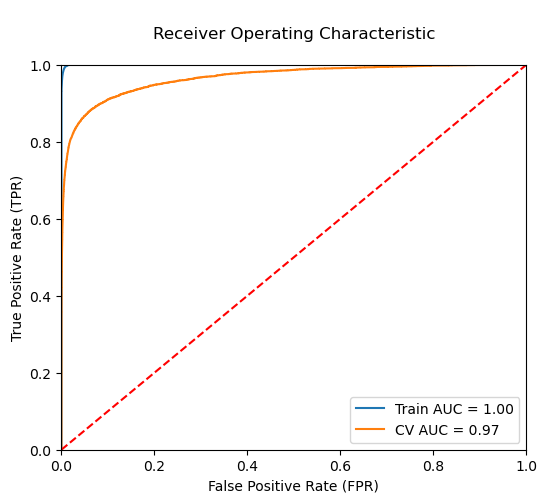

In [76]:
plt.rcParams["figure.figsize"] = (6, 5)
train_test_auc(train_fpr, train_tpr, train_roc_auc, test_fpr, test_tpr, test_roc_auc)

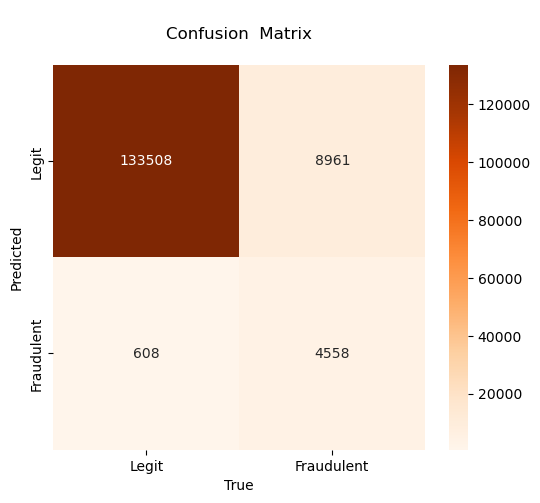

In [77]:
best_thr = best_threshold(test_threshold, test_tpr, test_fpr)
test_pred = class_label(best_thr, ensemble_test_proba)

draw_confusion_matrix(y_test, test_pred)

In [79]:
y_pred=ensemble.predict(X_test1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    142469
           1       0.69      0.76      0.73      5166

    accuracy                           0.98    147635
   macro avg       0.84      0.88      0.86    147635
weighted avg       0.98      0.98      0.98    147635



In [81]:
roc_auc_score(y_test, ensemble_test_proba)

0.9661165334723931